# SVM

In [14]:
import pandas as pd
import numpy as np
import pickle
import time

from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, plot_confusion_matrix, confusion_matrix

from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE

from category_encoders import TargetEncoder

import warnings
warnings.filterwarnings('ignore')

In [15]:
X_train = pd.read_csv('Data/X_train.csv', index_col='building_id')
X_test = pd.read_csv('Data/X_test.csv', index_col='building_id')
y_train = pd.read_csv('Data/y_train.csv', index_col='building_id')
y_test = pd.read_csv('Data/y_test.csv', index_col='building_id')

In [16]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [17]:
#Create a dictionary and helper function to track model scores.
score_dict = {}
def print_scores():
    for key in score_dict.keys():
        print(f'{key}, f1_micro_score: {round(score_dict[key][0],4)}, Run time: {round(score_dict[key][1],0)}')

### Divide Columns

In [18]:
binary_cols = []
for col in X_train.columns:
    if col.startswith('has'):
        binary_cols.append(col)

cat_cols = list(X_train.select_dtypes(include='object').columns)

integer_cols = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

geo_cols = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

all_cols = geo_cols + cat_cols + integer_cols + binary_cols

### Sample X_train, y_train for faster modeling

Due to computational limitations, I will use a sampled train set to evaluate SVM models first.  Once I have selected a tuned model, I will fit the model to the full train set.

In [19]:
X_train_sample, X_train_leftover, y_train_sample, y_train_leftover = \
    train_test_split(X_train, y_train, test_size=.9, random_state=42)

### svm0:  Basline SVM with no feature engineering

In [21]:
ohe_pipe = imbPipeline([('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

transformer = ColumnTransformer([
    ('binary', 'passthrough', binary_cols),
    ('categorical', ohe_pipe, cat_cols),
    ('integer', 'passthrough', integer_cols),
    ('geo', 'passthrough', geo_cols)
])

In [34]:
svm0_pipe = imbPipeline([
    ('trans', transformer), 
    ('svm', SVC(random_state=42))
])

In [23]:
start = time.time()
f1_micro_svm0 = cross_val_score(svm0_pipe, X_train_sample, y_train_sample, scoring='f1_micro')
end = time.time()
print(f'Run time: {end-start}')
run_time_svm0 = (end-start)

Run time: 151.94065284729004


In [24]:
f1_micro_svm0 = f1_micro_svm0.mean()
f1_micro_svm0

0.5687899718598107

In [25]:
score_dict['svm0'] = [f1_micro_svm0, run_time_svm0]
print_scores()

svm0, f1_micro_score: 0.5688, Run time: 152.0


The baseline model performs no better than the dummy model.

### svm1:  log transform and scale integer columns, remove unimportant features

In [26]:
binary_cols_dropped = binary_cols.copy()
for col in binary_cols_dropped:
    if col.startswith('has_secondary'):
        binary_cols_dropped.remove(col)
binary_cols_dropped.append('has_secondary_use')

cat_cols_dropped = cat_cols.copy()
cat_cols_dropped.remove('legal_ownership_status')
cat_cols_dropped.remove('plan_configuration')

In [27]:
def log_transform(x):
    return np.log(x+1)

In [28]:
function_transformer = FunctionTransformer(log_transform)

ohe_pipe = imbPipeline([('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])
integer_pipe = imbPipeline([
    ('function', function_transformer),
    ('ss', StandardScaler())
])

transformer = ColumnTransformer([
    ('binary', 'passthrough', binary_cols_dropped),
    ('categorical', ohe_pipe, cat_cols_dropped),
    ('geo', 'passthrough', geo_cols),
    ('integer', integer_pipe, integer_cols),
])

In [30]:
svm1_pipe = imbPipeline([
    ('transformer', transformer),
    ('svm', SVC(random_state=42))
])

In [31]:
start = time.time()
f1_micro_svm1 = cross_val_score(svm1_pipe, X_train_sample, y_train_sample, scoring='f1_micro')
end = time.time()
print(f'Run time: {end-start}')
run_time_svm1 = end-start

Run time: 113.17395806312561


In [32]:
f1_micro_svm1 = f1_micro_svm1.mean()
f1_micro_svm1

0.5687899718598107

In [33]:
score_dict['svm1'] = [f1_micro_svm1, run_time_svm1]
print_scores()

svm0, f1_micro_score: 0.5688, Run time: 152.0
svm1, f1_micro_score: 0.5688, Run time: 113.0


### svm2:  Add Target Encoding

In [48]:
function_transformer = FunctionTransformer(log_transform)

ohe_pipe = imbPipeline([('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])
integer_pipe = imbPipeline([
    ('function', function_transformer),
    ('ss', StandardScaler())
])
target_pipe = imbPipeline([('target', TargetEncoder(cols=geo_cols))])

transformer = ColumnTransformer([
    ('binary', 'passthrough', binary_cols_dropped),
    ('categorical', ohe_pipe, cat_cols_dropped),
    ('geo', target_pipe, geo_cols),
    ('integer', integer_pipe, integer_cols),
])

In [36]:
svm2_pipe = imbPipeline([
    ('transformer', transformer),
    ('svm', SVC(random_state=42))
])

In [37]:
start = time.time()
f1_micro_svm2 = cross_val_score(svm2_pipe, X_train_sample, y_train_sample, scoring='f1_micro')
end = time.time()
print(f'Run time: {end-start}')
run_time_svm2 = end-start

Run time: 79.62519788742065


In [38]:
f1_micro_svm2 = f1_micro_svm2.mean()
f1_micro_svm2

0.6871322588897416

In [39]:
score_dict['svm2'] = [f1_micro_svm2, run_time_svm2]
print_scores()

svm0, f1_micro_score: 0.5688, Run time: 152.0
svm1, f1_micro_score: 0.5688, Run time: 113.0
svm2, f1_micro_score: 0.6871, Run time: 80.0


### svm3:  Try using SMOTE

In [41]:
svm3_pipe = imbPipeline([
    ('transformer', transformer),
    ('smote', SMOTE(n_jobs=-1, random_state=42)),
    ('svm', SVC(random_state=42))
])

In [42]:
start = time.time()
f1_micro_svm3 = cross_val_score(svm3_pipe, X_train_sample, y_train_sample, scoring='f1_micro')
end = time.time()
print(f'Run time: {end-start}')
run_time_svm3 = end-start

Run time: 212.73533582687378


In [43]:
f1_micro_svm3 = f1_micro_svm3.mean()
f1_micro_svm3

0.6605781529803019

In [44]:
score_dict['svm3'] = [f1_micro_svm3, run_time_svm3]
print_scores()

svm0, f1_micro_score: 0.5688, Run time: 152.0
svm1, f1_micro_score: 0.5688, Run time: 113.0
svm2, f1_micro_score: 0.6871, Run time: 80.0
svm3, f1_micro_score: 0.6606, Run time: 213.0


SMOTE decreases the performance of the model, both in terms of the f1-micro score and run time.  

### GridsearchCV

Let's try a small GridSearchCV.

In [45]:
start = time.time()
svm_param_grid = {'svm__C': [.001, 1, 100],
                  'svm__gamma': ['scale', 0.001, 1, 1000]}

svm_gs = GridSearchCV(estimator=svm2_pipe, param_grid=svm_param_grid, 
                          scoring='f1_micro', cv=3, n_jobs=-1, verbose=2)
svm_gs.fit(X_train_sample, y_train_sample)
end = time.time()
print(f'Run time: {end-start}')

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  8.2min finished


Run time: 515.0668952465057


In [46]:
svm_gs.best_params_

{'svm__C': 1, 'svm__gamma': 'scale'}

In [47]:
svm_gs.best_score_

0.6860066513174724

The gridsearch suggests using the default parameters. Let's now run the model on the full training set.

### svm4:  Running the best model with default parameters on the full training set.

In [50]:
svm4_pipe = imbPipeline([
    ('transformer', transformer),
    ('svm', SVC(verbose=2, random_state=42))
])

In [51]:
start = time.time()
f1_micro_svm4 = cross_val_score(svm4_pipe, X_train, y_train, scoring='f1_micro')
end = time.time()
print(f'Run time: {end-start}')
run_time_svm4 = end-start

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Run time: 58261.620429992676


In [52]:
f1_micro_svm4 = f1_micro_svm4.mean()
f1_micro_svm4

0.7317114351496545

In [53]:
score_dict['svm4'] = [f1_micro_svm4, run_time_svm4]
print_scores()

svm0, f1_micro_score: 0.5688, Run time: 152.0
svm1, f1_micro_score: 0.5688, Run time: 113.0
svm2, f1_micro_score: 0.6871, Run time: 80.0
svm3, f1_micro_score: 0.6606, Run time: 213.0
svm4, f1_micro_score: 0.7317, Run time: 58262.0


### Checking the final model's performance on the test set

In [54]:
svm4_pipe.fit(X_train, y_train)

[LibSVM]

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('binary', 'passthrough',
                                                  ['has_superstructure_adobe_mud',
                                                   'has_superstructure_mud_mortar_stone',
                                                   'has_superstructure_stone_flag',
                                                   'has_superstructure_cement_mortar_stone',
                                                   'has_superstructure_mud_mortar_brick',
                                                   'has_superstructure_cement_mortar_brick',
                                                   'has_superstructure_timber',
                                                   'has_superstr...
                                                                                       'geo_level_2_id',
                                                                                       'geo_level_3_id']))]

In [56]:
svm4_preds = svm4_pipe.predict(X_test)
svm4_test_score = f1_score(y_test, svm4_preds, average='micro')
svm4_test_score

0.7345397614771839

### Plot confusion matrix and check model's target accuracies

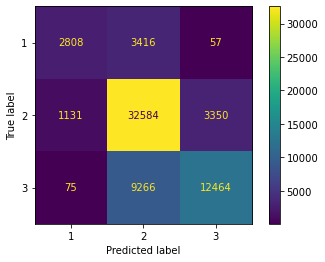

In [57]:
plot_confusion_matrix(svm4_pipe, X_test, y_test);

In [58]:
cm = confusion_matrix(y_test, svm4_preds)
low_damage = cm[0][0] / (cm[0][0] + cm[0][1] + cm[0][2])
medium_damage = cm[1][1] / (cm[1][0] + cm[1][1] + cm[1][2])
complete_destruction = cm[2][2] / (cm[2][0] + cm[2][1] + cm[2][2])
print(f'The model correctly predicts {round(low_damage*100, 2)}% of low damage.')
print(f'The model correctly predicts {round(medium_damage*100, 2)}% of medium damage.')
print(f'The model correctly predicts {round(complete_destruction*100, 2)}% of complete destruction.')

The model correctly predicts 44.71% of low damage.
The model correctly predicts 87.91% of medium damage.
The model correctly predicts 57.16% of complete destruction.


### Export the model

In [55]:
#with open ('../Models/svm4.pickle', 'wb') as f:
#    pickle.dump(svm4_pipe, f, pickle.HIGHEST_PROTOCOL)